# NLP Methods on Music Reviews
This project explores text preprocessing, lexicon normalization, and modeling of music reviews, retrieved from the Kaggle dataset [song reviews](https://www.kaggle.com/nolanbconaway/pitchfork-data)

In [118]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
import numpy as np
import seaborn as sns
import sqlite3
import string, re
import langdetect 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.collocations import * 
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Khyatee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Khyatee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Khyatee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Import Data
The data is stored as a series of tables within a sqlite database. The following cells extract each table and convert them to Pandas dataframes.

### Connect to the Database

In [2]:
connection = sqlite3.connect('datasets/reviews.sqlite')
cursor = connection.cursor()

### Reviews Table

In [3]:
query = "select * from reviews;"
cursor.execute(query)
df_reviews = pd.DataFrame(cursor.fetchall(), columns=["id",'track', 'artist', 'url','score',
    'best_new_music', 'author', 'author_type','date','weekday', 'day', 'month', 'year'])
df_reviews.head()

,id,track,artist,url,score,best_new_music,author,author_type,date,weekday,day,month,year
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017


### Content Table

In [4]:
query = "select * from content;"
cursor.execute(query)
df_content = pd.DataFrame(cursor.fetchall(), columns=["id",'review'])
df_content.head()

,id,review
0,22703,"“Trip-hop” eventually became a ’90s punchline,..."
1,22721,"Eight years, five albums, and two EPs in, the ..."
2,22659,Minneapolis’ Uranium Club seem to revel in bei...
3,22661,Kleenex began with a crash. It transpired one ...
4,22725,It is impossible to consider a given release b...


### Genres Table

In [5]:
query = "select * from genres;"
cursor.execute(query)
df_genres = pd.DataFrame(cursor.fetchall(), columns=["id",'genre'])
df_genres.head()

,id,genre
0,22703,electronic
1,22721,metal
2,22659,rock
3,22661,rock
4,22725,electronic


# Data Prep
The following cells perform text preprocessing steps, such as stop word / punctuation removal

## Merge Dataframes

In [6]:
df = df_content.merge(df_reviews, on='id')
df.sample(5)

,id,review,track,artist,url,score,best_new_music,author,author_type,date,weekday,day,month,year
14742,5601,Located about halfway between Manchester and L...,out to go,moco,http://pitchfork.com/reviews/albums/5601-out-t...,7.2,0,joe tangari,contributor,2004-08-01,6,1,8,2004
11106,10527,\r\n There really ought to be more bands li...,colossal youth and collected works,young marble giants,http://pitchfork.com/reviews/albums/10527-colo...,9.3,0,douglas wolk,contributor,2007-08-10,4,10,8,2007
466,22234,London-based producer Lexxi’s “Red Eyez” serve...,5tarb01,lexxi,http://pitchfork.com/reviews/albums/22234-5tar...,8.0,0,thea ballard,contributor,2016-08-17,2,17,8,2016
10993,10611,\r\n Though it has always been her pet proj...,supermoon,zap mama,http://pitchfork.com/reviews/albums/10611-supe...,7.7,0,roque strew,None,2007-09-13,3,13,9,2007
12912,1769,Vocalist Nirmala Basnayake may be the face of ...,x-amounts,controller.controller,http://pitchfork.com/reviews/albums/1769-x-amo...,7.1,0,joe tangari,contributor,2006-02-19,6,19,2,2006


## Create target variable

In [7]:
df =df[(df.score>8) | (df.score<6)]

In [8]:
df['target']=np.where(df.score>8, 1,0)

In [76]:
df.target.value_counts()

0    3004
1    2980
Name: target, dtype: int64

In [96]:
df = df.loc[:,['review', 'target']]
reviews = df['review']
target = df['target']
df.head()

,review,target
0,"“Trip-hop” eventually became a ’90s punchline,...",1
3,Kleenex began with a crash. It transpired one ...,1
4,It is impossible to consider a given release b...,1
9,There were innumerable cameos at the Bad Boy F...,0
11,"On 2006’s “That’s Life,” Killer Mike boasted “...",1


## Stopword Removal

In [106]:
# define a function that removes stopwords
def remove_stopwords(article):
    tokens = nltk.word_tokenize(article)
    
    stopword_list = stopwords.words('english')
    stopword_list += list(string.punctuation)
    stopword_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©',
                "n't", "'s", "'re", '-', '–', '—','\r\n','\r','\n', '--']

    stopword_set = set(stopword_list)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopword_set]
    
    ## back to string from list
    text = " ".join(stopwords_removed)
    return text

In [107]:
df['stopped'] = df['review'].apply(lambda x: remove_stopwords(x))
df.head()

,review,target,lang,stopped
0,"“Trip-hop” eventually became a ’90s punchline,...",1,en,trip-hop eventually became 90s punchline music...
3,Kleenex began with a crash. It transpired one ...,1,en,kleenex began crash transpired one night long ...
4,It is impossible to consider a given release b...,1,en,impossible consider given release footwork art...
9,There were innumerable cameos at the Bad Boy F...,0,en,innumerable cameos bad boy family reunion tour...
11,"On 2006’s “That’s Life,” Killer Mike boasted “...",1,en,2006 life killer mike boasted hard-pressed fin...


## Language Detection

In [108]:
df['lang'] = df['review'].apply(lambda x: langdetect.detect(x) if x.strip() != "" else "")

# drop non english reviews (only 5 of them, empty reviews)
df.drop(df[df['lang']!='en'].index, inplace=True)
df.head()

,review,target,lang,stopped
0,"“Trip-hop” eventually became a ’90s punchline,...",1,en,trip-hop eventually became 90s punchline music...
3,Kleenex began with a crash. It transpired one ...,1,en,kleenex began crash transpired one night long ...
4,It is impossible to consider a given release b...,1,en,impossible consider given release footwork art...
9,There were innumerable cameos at the Bad Boy F...,0,en,innumerable cameos bad boy family reunion tour...
11,"On 2006’s “That’s Life,” Killer Mike boasted “...",1,en,2006 life killer mike boasted hard-pressed fin...


## Lemmatization
Create a function to lemmatize reviews, and apply it to each review with stopwords removed as a new column called "lemmed"

In [115]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer() 
    lemmed = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return(lemmed)

In [117]:
df['lemmed'] = df['stopped'].apply(lambda x: lemmatize(x))
df.head()

,review,target,lang,stopped,lemmed
0,"“Trip-hop” eventually became a ’90s punchline,...",1,en,trip-hop eventually became 90s punchline music...,trip-hop eventually became 90 punchline music-...
3,Kleenex began with a crash. It transpired one ...,1,en,kleenex began crash transpired one night long ...,kleenex began crash transpired one night long ...
4,It is impossible to consider a given release b...,1,en,impossible consider given release footwork art...,impossible consider given release footwork art...
9,There were innumerable cameos at the Bad Boy F...,0,en,innumerable cameos bad boy family reunion tour...,innumerable cameo bad boy family reunion tour ...
11,"On 2006’s “That’s Life,” Killer Mike boasted “...",1,en,2006 life killer mike boasted hard-pressed fin...,2006 life killer mike boasted hard-pressed fin...


## Stemming
Create a function to stemm reviews, and apply it to each review with stopwords removed as a new column called "stemmed"

In [119]:
def stemm(text):
    stemmer = PorterStemmer()
    stemmed = ' '.join([stemmer.stem(word) for word in text.split()])
    return(stemmed)

In [121]:
df['stemmed'] = df['stopped'].apply(lambda x: stemm(x))
df.head()

,review,target,lang,stopped,lemmed,stemmed
0,"“Trip-hop” eventually became a ’90s punchline,...",1,en,trip-hop eventually became 90s punchline music...,trip-hop eventually became 90 punchline music-...,trip-hop eventu becam 90 punchlin music-press ...
3,Kleenex began with a crash. It transpired one ...,1,en,kleenex began crash transpired one night long ...,kleenex began crash transpired one night long ...,kleenex began crash transpir one night long fo...
4,It is impossible to consider a given release b...,1,en,impossible consider given release footwork art...,impossible consider given release footwork art...,imposs consid given releas footwork artist wit...
9,There were innumerable cameos at the Bad Boy F...,0,en,innumerable cameos bad boy family reunion tour...,innumerable cameo bad boy family reunion tour ...,innumer cameo bad boy famili reunion tour ofte...
11,"On 2006’s “That’s Life,” Killer Mike boasted “...",1,en,2006 life killer mike boasted hard-pressed fin...,2006 life killer mike boasted hard-pressed fin...,2006 life killer mike boast hard-press find an...


### Flatten list of lists

In [19]:
flat_best_reviews = [item for sublist in best_reviews_stopped for item in sublist]
flat_not_best_reviews = [item for sublist in not_best_reviews_stopped for item in sublist]

In [20]:
best_freq = FreqDist(flat_best_reviews)
not_best_freq = FreqDist(flat_not_best_reviews)

# Exploratory Data Analysis

## Bag of Words

In [21]:
best_freq.most_common(20)

[('like', 11997),
 ('album', 8764),
 ('music', 8556),
 ('one', 7670),
 ('band', 6777),
 ('songs', 5446),
 ('sound', 4776),
 ('song', 4756),
 ('even', 4715),
 ('record', 4355),
 ('time', 4304),
 ('new', 4293),
 ('first', 4221),
 ('two', 3374),
 ('way', 3294),
 ('guitar', 3255),
 ('sounds', 3249),
 ('much', 3246),
 ('would', 3236),
 ('rock', 3233)]

In [22]:
not_best_freq.most_common(20)

[('like', 10488),
 ('album', 7063),
 ('one', 5400),
 ('band', 5146),
 ('music', 4595),
 ('songs', 4325),
 ('even', 4284),
 ('song', 3945),
 ('sound', 3450),
 ('much', 3176),
 ('record', 3091),
 ('new', 2890),
 ('time', 2821),
 ('could', 2656),
 ('rock', 2643),
 ('sounds', 2623),
 ('first', 2619),
 ('would', 2584),
 ('track', 2531),
 ('way', 2375)]

### Normalized Word Frequencies

In [23]:
best_reviews_total_word_count = sum(best_freq.values())
best_top_25 = best_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in best_top_25:
    normalized_frequency = word[1]/best_reviews_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

like 		 0.008319
album 		 0.006077
music 		 0.005933
one 		 0.005319
band 		 0.004699
songs 		 0.003776
sound 		 0.003312
song 		 0.003298
even 		 0.00327
record 		 0.00302
time 		 0.002985
new 		 0.002977
first 		 0.002927
two 		 0.00234
way 		 0.002284
guitar 		 0.002257
sounds 		 0.002253
much 		 0.002251
would 		 0.002244
rock 		 0.002242
also 		 0.002182
track 		 0.002179
could 		 0.002171
tracks 		 0.002082
still 		 0.002064


In [24]:
not_best_reviews_total_word_count = sum(not_best_freq.values())
not_best_top_25 = not_best_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in not_best_top_25:
    normalized_frequency = word[1]/not_best_reviews_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

like 		 0.009778
album 		 0.006585
one 		 0.005035
band 		 0.004798
music 		 0.004284
songs 		 0.004032
even 		 0.003994
song 		 0.003678
sound 		 0.003217
much 		 0.002961
record 		 0.002882
new 		 0.002694
time 		 0.00263
could 		 0.002476
rock 		 0.002464
sounds 		 0.002446
first 		 0.002442
would 		 0.002409
track 		 0.00236
way 		 0.002214
get 		 0.002151
still 		 0.002129
tracks 		 0.002119
two 		 0.002095
little 		 0.001991


## Word Clouds

In [25]:
top_words_best = [x[0] for x in best_freq.most_common(25)]
top_words_best_count = [x[1] for x in best_freq.most_common(25)]

top_words_not_best = [x[0] for x in not_best_freq.most_common(25)]
top_words_not_best_count = [x[1] for x in not_best_freq.most_common(25)]

In [26]:
from wordcloud import WordCloud
best_dictionary = dict(zip(top_words_best, top_words_best_count))
not_best_dictionary = dict(zip(top_words_not_best, top_words_not_best_count))

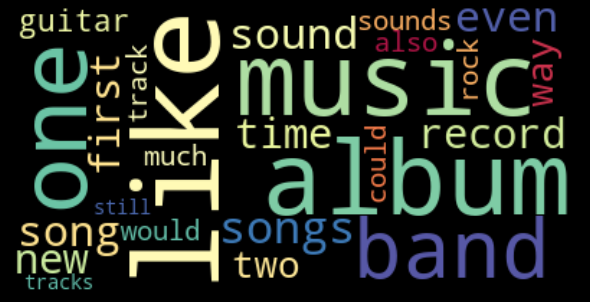

In [27]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(best_dictionary)

plt.figure(figsize=(8,8), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

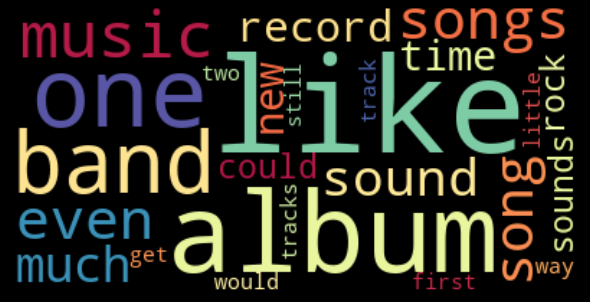

In [28]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(not_best_dictionary)

plt.figure(figsize=(8,8), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Bigrams
### Raw Frequency

In [54]:
bigram_measures = nltk.collocations.BigramAssocMeasures() 

best_bigrams_finder = BigramCollocationFinder.from_words(flat_best_reviews)
not_best_bigrams_finder = BigramCollocationFinder.from_words(flat_not_best_reviews)

In [55]:
# bigram scores
scored_best = best_bigrams_finder.score_ngrams(bigram_measures.raw_freq)  
scored_not_best = not_best_bigrams_finder.score_ngrams(bigram_measures.raw_freq)


In [56]:
scored_best[:5]

[(('sounds', 'like'), 0.0006344948865953074),
 (('sound', 'like'), 0.00040011316892403536),
 (('title', 'track'), 0.00036336100609392466),
 (('new', 'york'), 0.00035642663574862076),
 (('feels', 'like'), 0.0003418644580234826)]

In [57]:
scored_not_best[:5]

[(('sounds', 'like'), 0.000897833452360752),
 (('sound', 'like'), 0.0005957586459590036),
 (('title', 'track'), 0.000415819023627098),
 (('feels', 'like'), 0.00035614992606625883),
 (('last', 'year'), 0.0002946161692066434)]

## Pointwise Mutual Information

In [72]:
best_pmi_finder = BigramCollocationFinder.from_words(flat_best_reviews)
not_best_pmi_finder = BigramCollocationFinder.from_words(flat_not_best_reviews)

best_pmi_finder.apply_freq_filter(10)
not_best_pmi_finder.apply_freq_filter(10)

In [73]:
pmi_best = best_pmi_finder.score_ngrams(bigram_measures.pmi)
pmi_not_best = not_best_pmi_finder.score_ngrams(bigram_measures.pmi)

In [74]:
pmi_best[:10]

[(('lali', 'puna'), 17.137803680423247),
 (('bitte', 'orca'), 16.874769274589454),
 (('blitzen', 'trapper'), 16.874769274589454),
 (('träd', 'gräs'), 16.874769274589454),
 (('charli', 'xcx'), 16.759292057169517),
 (('creedence', 'clearwater'), 16.759292057169517),
 (('jewelled', 'antler'), 16.759292057169517),
 (('os', 'mutantes'), 16.73726575083952),
 (('gräs', 'och'), 16.652376853253006),
 (('och', 'stenar'), 16.652376853253003)]

In [75]:
pmi_not_best[:10]

[(('inspiral', 'carpets'), 16.573224898151672),
 (('hüsker', 'dü'), 16.332216798647877),
 (('olivia', 'tremor'), 16.225301594731366),
 (('otis', 'redding'), 16.225301594731366),
 (('clint', 'eastwood'), 16.225301594731363),
 (('marvin', 'gaye'), 16.03265651678897),
 (('avey', 'tare'), 16.010288703760516),
 (('suspension', 'disbelief'), 15.769622110955174),
 (('joanna', 'newsom'), 15.738742798071204),
 (('lex', 'luger'), 15.710728421901607)]

# Feature Engineering
POS tagging
## Length Analysis

In [124]:
df['word_count'] = df["review"].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df["review"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
df['sentence_count'] = df["review"].apply(lambda x: len(str(x).split(".")))
df['avg_word_length'] = df['char_count'] / df['word_count']
df['avg_sentence_length'] = df['word_count'] / df['sentence_count']
df.head()

,review,target,lang,stopped,lemmed,stemmed,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
0,"“Trip-hop” eventually became a ’90s punchline,...",1,en,trip-hop eventually became 90s punchline music...,trip-hop eventually became 90 punchline music-...,trip-hop eventu becam 90 punchlin music-press ...,1432,7879,53,5.502095,27.018868
3,Kleenex began with a crash. It transpired one ...,1,en,kleenex began crash transpired one night long ...,kleenex began crash transpired one night long ...,kleenex began crash transpir one night long fo...,1155,6563,66,5.682251,17.500000
4,It is impossible to consider a given release b...,1,en,impossible consider given release footwork art...,impossible consider given release footwork art...,imposs consid given releas footwork artist wit...,526,2685,25,5.104563,21.040000
9,There were innumerable cameos at the Bad Boy F...,0,en,innumerable cameos bad boy family reunion tour...,innumerable cameo bad boy family reunion tour ...,innumer cameo bad boy famili reunion tour ofte...,1003,5178,40,5.162512,25.075000
11,"On 2006’s “That’s Life,” Killer Mike boasted “...",1,en,2006 life killer mike boasted hard-pressed fin...,2006 life killer mike boasted hard-pressed fin...,2006 life killer mike boast hard-press find an...,813,4066,32,5.001230,25.406250


## Sentiment Analysis

## PoS Analysis

In [129]:
tokens = nltk.word_tokenize(df['review'][0])
nltk.pos_tag(tokens)

[('“', 'JJ'),
 ('Trip-hop', 'NNP'),
 ('”', 'NNP'),
 ('eventually', 'RB'),
 ('became', 'VBD'),
 ('a', 'DT'),
 ('’', 'NN'),
 ('90s', 'CD'),
 ('punchline', 'NN'),
 (',', ','),
 ('a', 'DT'),
 ('music-press', 'JJ'),
 ('shorthand', 'NN'),
 ('for', 'IN'),
 ('“', 'NNP'),
 ('overhyped', 'VBD'),
 ('hotel', 'NN'),
 ('lounge', 'NN'),
 ('music.', 'NN'),
 ('”', 'NN'),
 ('But', 'CC'),
 ('today', 'NN'),
 (',', ','),
 ('the', 'DT'),
 ('much-maligned', 'JJ'),
 ('subgenre', 'NN'),
 ('almost', 'RB'),
 ('feels', 'NNS'),
 ('like', 'IN'),
 ('a', 'DT'),
 ('secret', 'JJ'),
 ('precedent', 'NN'),
 ('.', '.'),
 ('Listen', 'VB'),
 ('to', 'TO'),
 ('any', 'DT'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('canonical', 'JJ'),
 ('Bristol-scene', 'NNP'),
 ('albums', 'NNS'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('mid-late', 'JJ'),
 ('’', 'NN'),
 ('90s', 'CD'),
 (',', ','),
 ('when', 'WRB'),
 ('the', 'DT'),
 ('genre', 'NN'),
 ('was', 'VBD'),
 ('starting', 'VBG'),
 ('to', 'TO'),
 ('chafe', 'VB'),
 ('against', 'IN'),
 ('its', 'PRP$'),
 ('

### Stopwords

In [ ]:
reviews_stopped = list(map(remove_stopwords, reviews))
best_reviews_stopped = list(map(remove_stopwords, df['review'][df['target']==1]))
not_best_reviews_stopped = list(map(remove_stopwords, df['review'][df['target']==0]))

### Train/Test Split

In [37]:
# lemmatized words
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.20, random_state=1)


In [38]:
# stemmed words
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(X_stem, y_stem, test_size=0.20, random_state=1)


# TF-IDF Vectorization

In [39]:
tfidf = TfidfVectorizer()
tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem = tfidf.transform(X_test_lem)


In [40]:
# get a quick look of the non zero elements

non_zero_cols = tfidf_data_train_lem.nnz / float(tfidf_data_train_lem.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train_lem.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 337.60998537706286
Percentage of columns containing ZERO: 0.9949926585085644


# T-SNE

In [42]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(tfidf_data_train_lem)

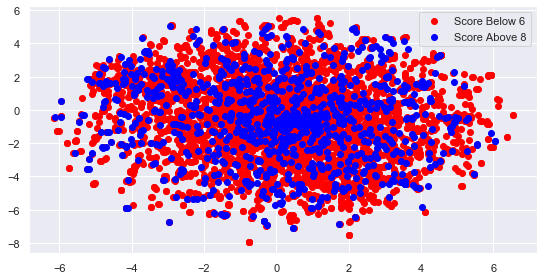

In [53]:
best_2d = X_embedded[:943]
best_x = [i[0] for i in best_2d]
best_y = [i[1] for i in best_2d]

not_best_2d = X_embedded[943:]
not_best_x = [i[0] for i in not_best_2d]
not_best_y = [i[1] for i in not_best_2d]

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(222)
ax.scatter(not_best_x, not_best_y, c='red', label='Score Below 6')
ax.scatter(best_x, best_y, c='blue', label='Score Above 8')

ax.legend()
plt.show()

# Classification
### Random Forest using TF-IDF with lemmatized tokens

In [44]:
forest_lem = RandomForestClassifier(n_estimators=100, random_state=0)
forest_lem.fit(tfidf_data_train_lem, y_train_lem)
forest_test_preds_lem = forest_lem.predict(tfidf_data_test_lem)

In [45]:
forest_acc_score_lem = accuracy_score(y_test_lem, forest_test_preds_lem)
forest_f1_score_lem = f1_score(y_test_lem, forest_test_preds_lem)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(forest_acc_score_lem))
print()
print("F1 Score: {:.4}".format(forest_f1_score_lem))

Random Forest with Lemmatization Features
Testing Accuracy: 0.787

F1 Score: 0.7713


### Confusion Matrix

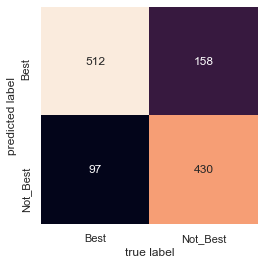

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()


mat = confusion_matrix(y_test_lem, forest_test_preds_lem)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Best', 'Not_Best'], yticklabels=['Best', 'Not_Best'])
plt.xlabel('true label')
plt.ylabel('predicted label');

### Random Forest using TF-IDF with stemmed tokens


In [47]:
tfidf = TfidfVectorizer()
tfidf_data_train_stem = tfidf.fit_transform(X_train_stem)
tfidf_data_test_stem = tfidf.transform(X_test_stem)

In [48]:
forest_stem = RandomForestClassifier(n_estimators=100, random_state=0)
forest_stem.fit(tfidf_data_train_stem, y_train_stem)
forest_test_preds_stem = forest_stem.predict(tfidf_data_test_stem)

In [49]:
forest_acc_score_stem = accuracy_score(y_test_stem, forest_test_preds_stem)
forest_f1_score_stem = f1_score(y_test_stem, forest_test_preds_stem)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(forest_acc_score_stem))
print()
print("F1 Score: {:.4}".format(forest_f1_score_stem))

Random Forest with Lemmatization Features
Testing Accuracy: 0.7945

F1 Score: 0.7827


### Random Forest using Count Vectorization with Lemmatized tokens

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(stop_words=stopword_list)
vec_data_train_lem = vec.fit_transform(X_train_lem)
vec_data_test_lem = vec.transform(X_test_lem)

In [51]:
forest_lem = RandomForestClassifier(n_estimators=100, random_state=0)
forest_lem.fit(vec_data_train_lem, y_train_lem)
forest_test_preds_lem = forest_lem.predict(vec_data_test_lem)

In [52]:
forest_acc_score_lem = accuracy_score(y_test_lem, forest_test_preds_lem)
forest_f1_score_lem = f1_score(y_test_lem, forest_test_preds_lem)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(forest_acc_score_lem))
print()
print("F1 Score: {:.4}".format(forest_f1_score_lem))

Random Forest with Lemmatization Features
Testing Accuracy: 0.8237

F1 Score: 0.8189
